# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Utility-Functions" data-toc-modified-id="Utility-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Utility Functions</a></div><div class="lev1 toc-item"><a href="#Building-a-Convolutional-Neural-Network" data-toc-modified-id="Building-a-Convolutional-Neural-Network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Building a Convolutional Neural Network</a></div><div class="lev2 toc-item"><a href="#Model-Definition" data-toc-modified-id="Model-Definition-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Model Definition</a></div><div class="lev2 toc-item"><a href="#Data-Generator" data-toc-modified-id="Data-Generator-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Data Generator</a></div><div class="lev2 toc-item"><a href="#Training" data-toc-modified-id="Training-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Training</a></div><div class="lev2 toc-item"><a href="#Data-Augmentation" data-toc-modified-id="Data-Augmentation-24"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Data Augmentation</a></div><div class="lev1 toc-item"><a href="#Visualizing-Feature-Maps" data-toc-modified-id="Visualizing-Feature-Maps-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visualizing Feature Maps</a></div><div class="lev1 toc-item"><a href="#Dense-Layer-Visualization" data-toc-modified-id="Dense-Layer-Visualization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dense Layer Visualization</a></div><div class="lev1 toc-item"><a href="#Visualizing-Convnet-Filters" data-toc-modified-id="Visualizing-Convnet-Filters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualizing Convnet Filters</a></div>

In [ ]:
!pip install tensorflow
!pip install matplotlib
!pip install seaborn
!pip install pandas
!pip install numpy
!pip install pickle5  # Alternativa a pickle si es necesario


In [ ]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.0 MB/s eta 0:00:00


In [ ]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import pickle

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# Visualización de activaciones (puede que necesites instalar keras-vis, aunque ha sido descontinuado)
# Puedes probar con tf-keras-vis como alternativa
try:
    from vis.utils import utils
    from keras import activations
    from vis.visualization import visualize_activation, get_num_filters
    from vis.input_modifiers import Jitter
except ImportError:
    print("Keras-vis ha sido descontinuado. Puedes intentar usar 'tf-keras-vis' para visualizaciones.")


Keras-vis ha sido descontinuado. Puedes intentar usar 'tf-keras-vis' para visualizaciones.


# Utility Functions

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['acc'])
    acc = smooth_curve(history.history['acc'][:steps])
    val_acc = smooth_curve(history.history['val_acc'][:steps])
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])

    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()

    plt.figure(figsize=(6, 4))
    plt.plot(acc, c='#0c7cba', label='Train Acc')
    plt.plot(val_acc, c='#0f9d58', label='Val Acc')
    plt.xticks(range(0, len(acc), 5))
    plt.xlim(0, len(acc))
    plt.title('Train Accuracy: %.3f, Val Accuracy: %.3f' % (acc[-1], val_acc[-1]), fontsize=12)
    plt.legend()

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history

def jitter(img, amount=32):
    ox, oy = np.random.randint(-amount, amount+1, 2)
    return np.roll(np.roll(img, ox, -1), oy, -2), ox, oy

def reverse_jitter(img, ox, oy):
    return np.roll(np.roll(img, -ox, -1), -oy, -2)

def plot_image(img):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

# Building a Convolutional Neural Network

## Model Definition

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1',
                 input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2), name='maxpool_1'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model.add(MaxPooling2D((2, 2), name='maxpool_2'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model.add(MaxPooling2D((2, 2), name='maxpool_3'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model.add(MaxPooling2D((2, 2), name='maxpool_4'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', name='dense_1'))
model.add(Dense(256, activation='relu', name='dense_2'))
model.add(Dense(1, activation='sigmoid', name='output'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Data Generator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_dir = "/content/drive/MyDrive/Base de datos- Convolutional Neural "
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 298 images belonging to 2 classes.
Found 298 images belonging to 2 classes.


## Training

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1
)


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.5571 - loss: 0.6859 - val_accuracy: 0.8490 - val_loss: 0.4750
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 77s 295ms/step - accuracy: 0.9215 - loss: 0.2668 - val_accuracy: 0.9698 - val_loss: 0.1004
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 253ms/step - accuracy: 0.9156 - loss: 0.2281 - val_accuracy: 0.9664 - val_loss: 0.1240
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 267ms/step - accuracy: 0.9646 - loss: 0.1415 - val_accuracy: 0.9664 - val_loss: 0.0741
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 269ms/step - accuracy: 0.9675 - loss: 0.0727 - val_accuracy: 0.9832 - val_loss: 0.0510
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 230ms/step - accuracy: 0.9756 - loss: 0.0860 - val_accuracy: 0.9899 - val_loss: 0.0406
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 235ms/step - accuracy: 0.9727 - loss: 0.0805 - val_accuracy: 0.9799 - val_loss: 0.0461
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 247ms/step - accuracy: 0.9777 - loss: 0.0

In [ ]:
model.save('model.keras')

In [ ]:
import pickle

# Guardar el modelo en el nuevo formato recomendado
model.save('model.keras')

# Guardar el historial de entrenamiento
with open('history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)


In [ ]:
def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history['accuracy'])
    acc = smooth_curve(history['accuracy'][:steps])
    val_acc = smooth_curve(history['val_accuracy'][:steps])
    loss = smooth_curve(history['loss'][:steps])
    val_loss = smooth_curve(history['val_loss'][:steps])

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Cargar el historial
with open('history.pkl', 'rb') as file_pi:
    history = pickle.load(file_pi)

plot_compare(history)


## Data Augmentation

In [ ]:
model_aug = Sequential()
model_aug.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1',
                 input_shape=(150, 150, 3)))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_1'))
model_aug.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_2'))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_3'))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_4'))
model_aug.add(Flatten())
model_aug.add(Dropout(0.5))
model_aug.add(Dense(512, activation='relu', name='dense_1'))
model_aug.add(Dense(256, activation='relu', name='dense_2'))
model_aug.add(Dense(1, activation='sigmoid', name='output'))

In [ ]:
model_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_aug = model_aug.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=60,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=0
)


In [ ]:
model_aug.save('model_aug.keras')


In [ ]:
def load_history(filename):
    with open(filename, 'rb') as file:
        history = pickle.load(file)
    return history  # Retorna el diccionario directamente


In [ ]:
history_aug = load_history('history_aug.bin')

# Verifica que history_aug contiene las claves correctas
print("Claves en history_aug:", history_aug.keys())

# Asegúrate de que history_aug sea un diccionario con las claves esperadas
if isinstance(history_aug, dict):
    if 'accuracy' in history_aug and 'val_accuracy' in history_aug:
        plot_compare(history_aug, steps=50)
    else:
        print("Las claves 'accuracy' y 'val_accuracy' no se encuentran en history_aug")
else:
    print("history_aug no es un diccionario. Revisa el formato del archivo.")


FileNotFoundError: [Errno 2] No such file or directory: 'history_aug.bin'

# Visualizing Feature Maps

In [ ]:
img_path = '/content/drive/MyDrive/Base de datos- Convolutional Neural /train/cebras/zebra_1.jpg'

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


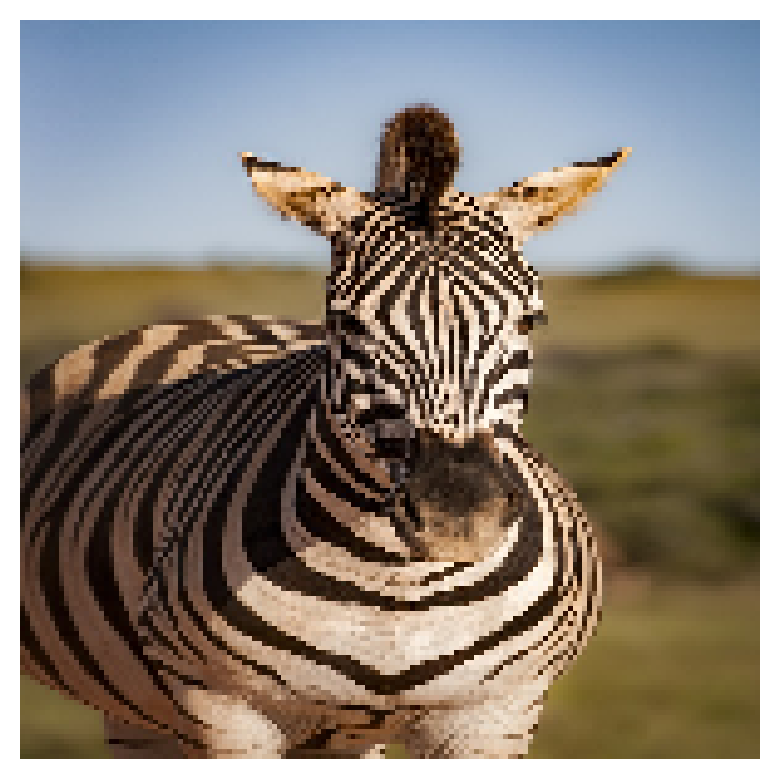

In [ ]:
plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

In [ ]:
vgg = VGG16(weights='imagenet', include_top=False)
vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


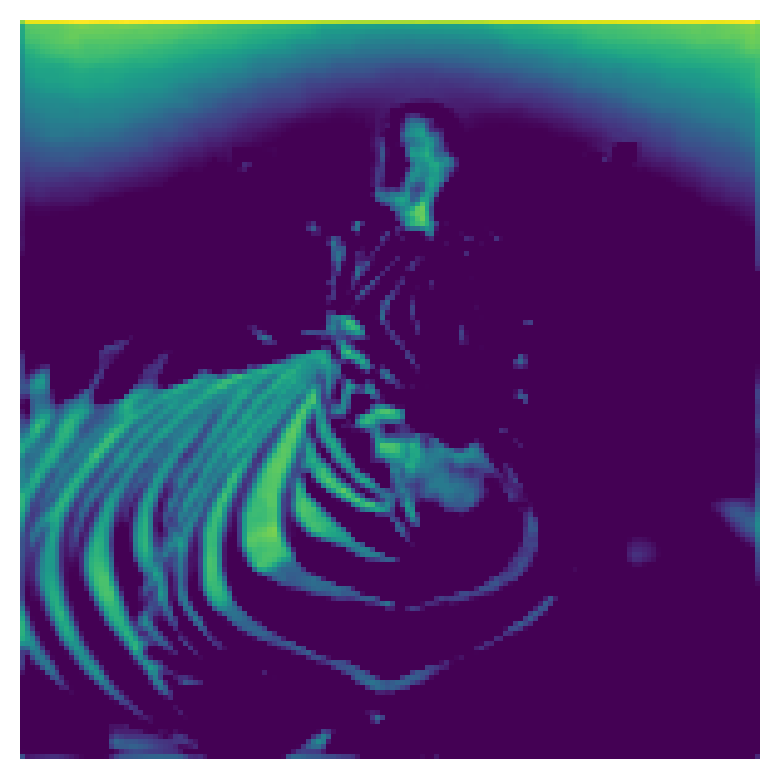

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in vgg.layers if 'conv1' in layer.name]
activation_model = Model(inputs=vgg.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

first_layer_activation = intermediate_activations[0]

plt.imshow(first_layer_activation[0, :, :, 19], cmap='viridis')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


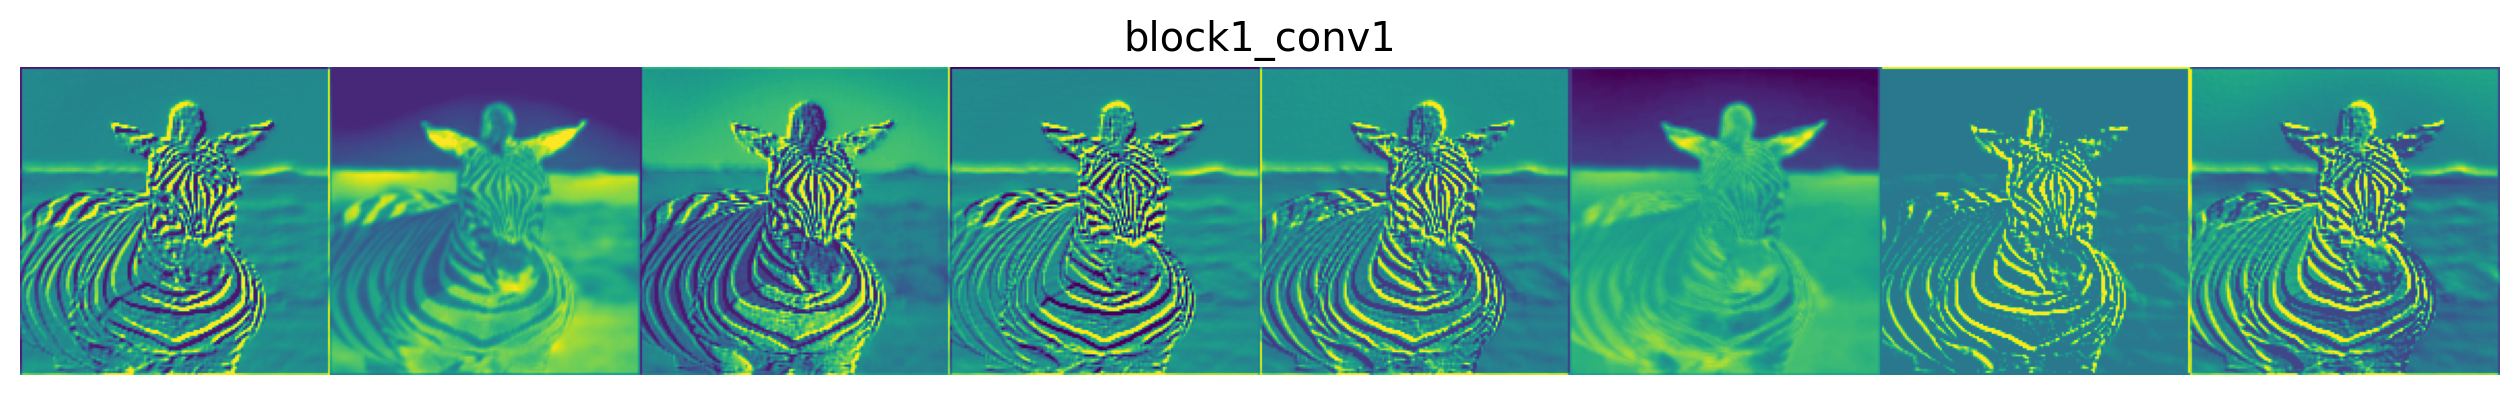

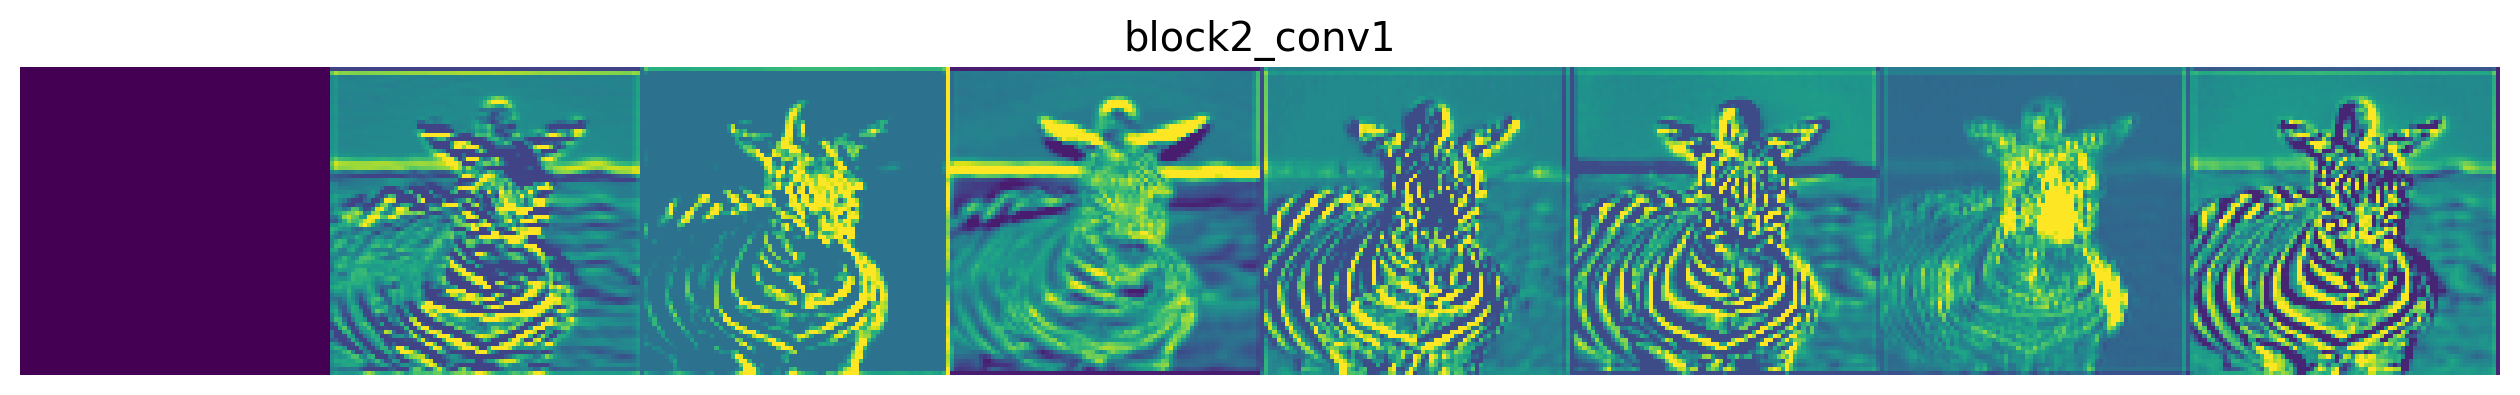

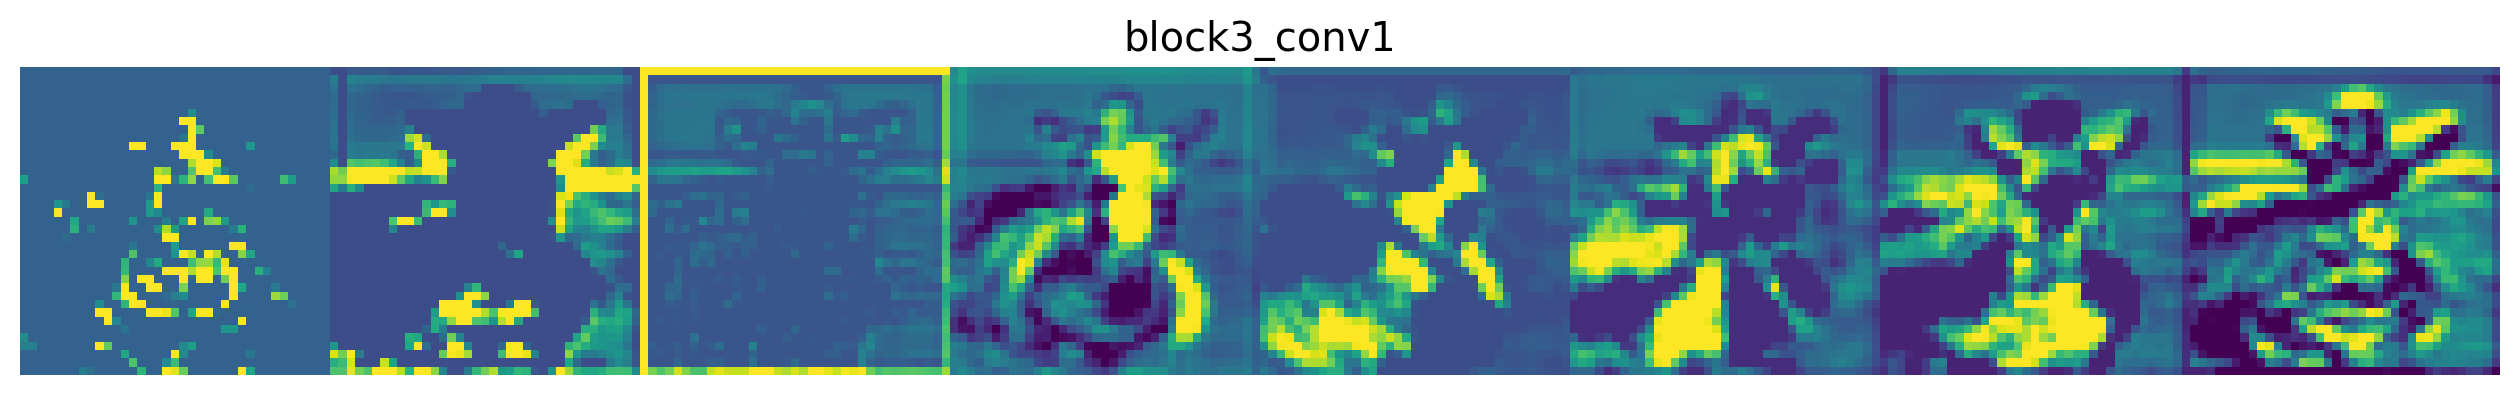

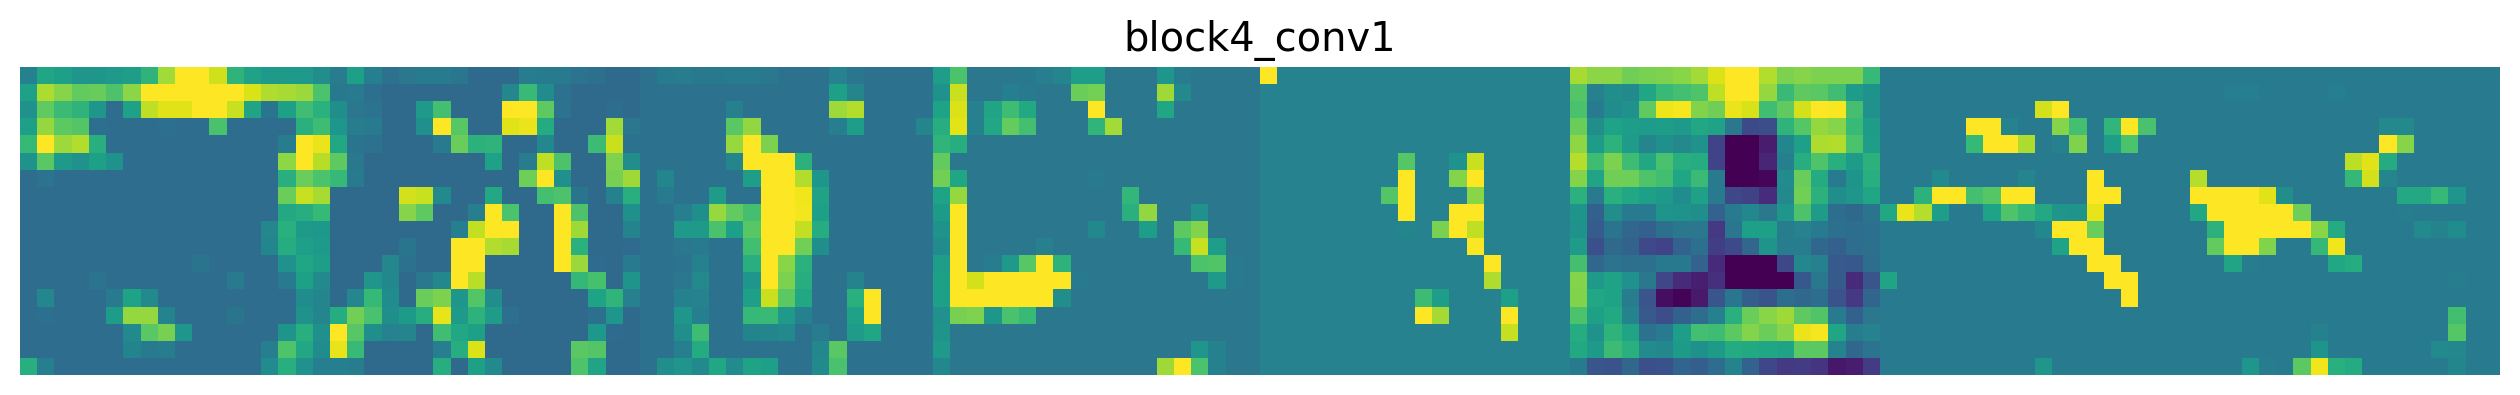

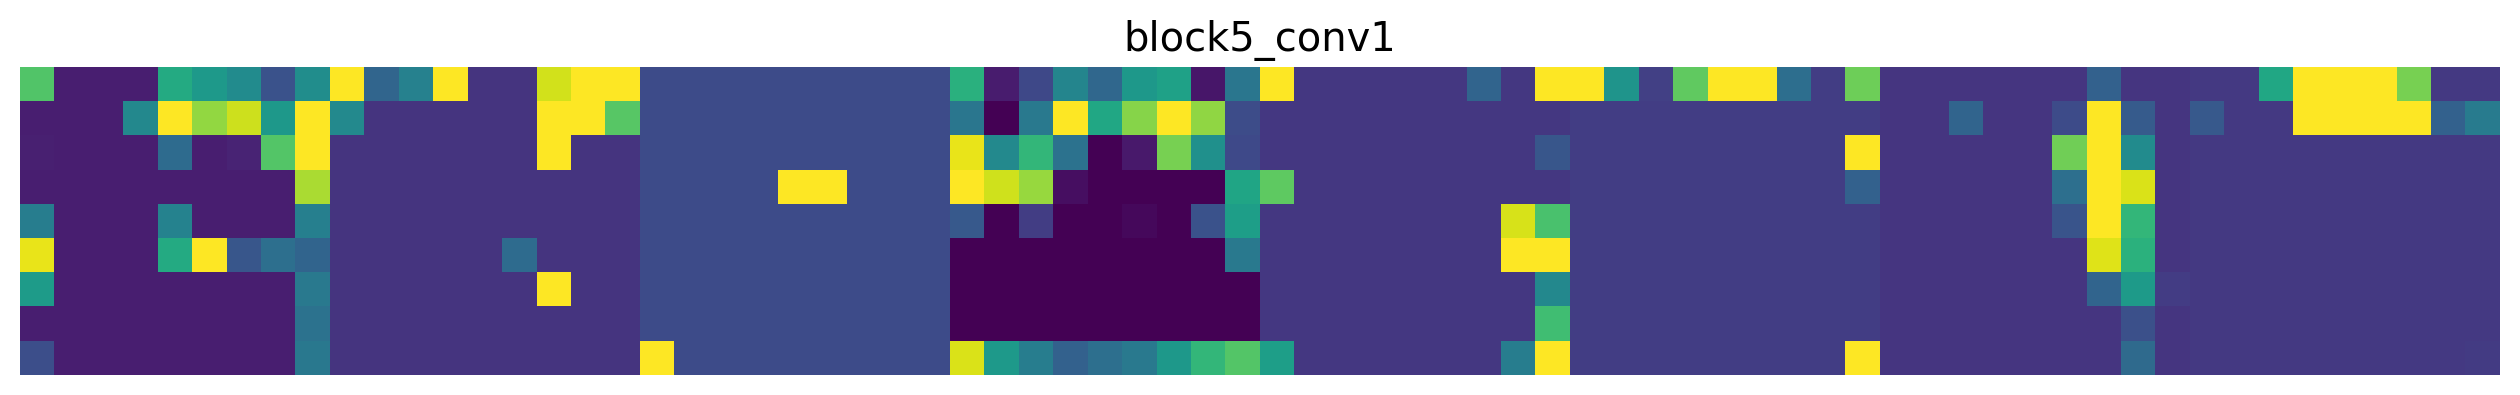

In [ ]:
layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

layer_outputs = [layer.output for layer in vgg.layers if layer.name in layer_names]
activation_model = Model(inputs=vgg.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

images_per_row = 8
max_images = 8
# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, intermediate_activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]
    n_features = min(n_features, max_images)

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 2. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.axis('off')
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

# Dense Layer Visualization

In [ ]:
!pip install tf-explain

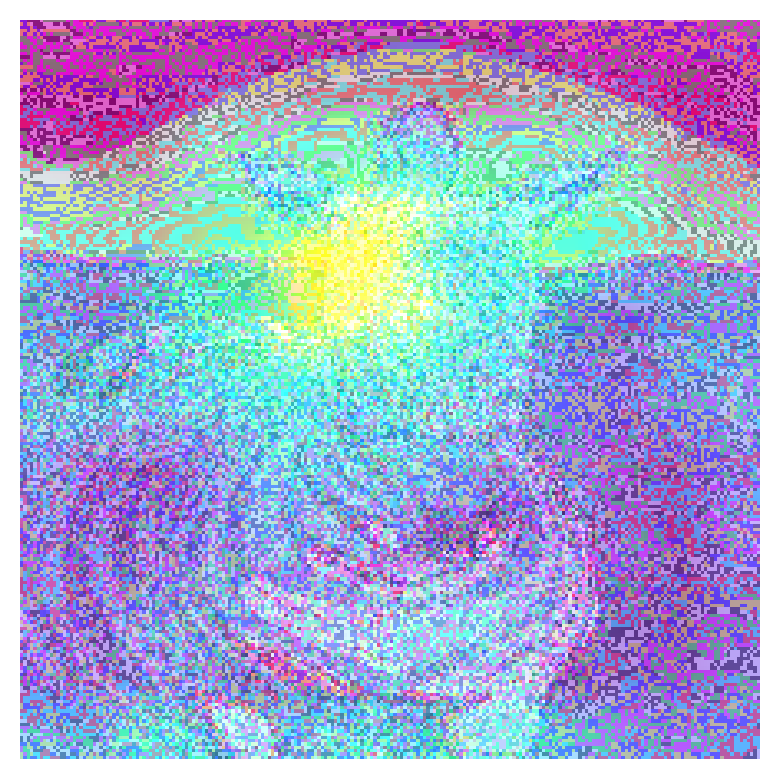

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tf_explain.core.grad_cam import GradCAM
import matplotlib.pyplot as plt
import numpy as np

# Cargar el modelo VGG16 con pesos preentrenados en ImageNet
model = VGG16(weights='imagenet', include_top=True)

# Prepara la imagen de entrada
def prepare_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Visualizar activación con Grad-CAM
def visualize_gradcam(model, img_array, layer_name, class_index):
    explainer = GradCAM()
    explanation = explainer.explain((img_array, None), model, class_index=class_index, layer_name=layer_name)
    return explanation

# Ruta de la imagen para la cual deseas visualizar las activaciones
img_path = '/content/drive/MyDrive/Base de datos- Convolutional Neural /train/cebras/zebra_1.jpg'
img_array = prepare_image(img_path)

# Encuentra el nombre de la capa para Grad-CAM (puedes elegir otra capa)
layer_name = 'block5_conv3'  # Nombre de la capa en VGG16 para visualizar
class_index = 20  # Índice de clase para 'ouzel' en ImageNet

# Visualizar la activación
gradcam_img = visualize_gradcam(model, img_array, layer_name, class_index)

# Mostrar la imagen
plt.imshow(gradcam_img)
plt.axis('off')
plt.show()


In [ ]:
!pip install tf-explain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tf_explain.core.grad_cam import GradCAM
from tensorflow.keras import backend as K

# Función para aplicar jitter (desviación aleatoria) a la imagen
def apply_jitter(image, jitter):
    # Crear un ruido aleatorio
    noise = np.random.uniform(-jitter, jitter, image.shape)
    jittered_image = np.clip(image + noise, 0, 255)
    return jittered_image

# Preparar la imagen de entrada
def prepare_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Visualizar activación con Grad-CAM
def visualize_gradcam(model, img_array, layer_name, class_index, jitter=16):
    # Aplicar jitter (desviación aleatoria) a la imagen
    img_array_jittered = apply_jitter(img_array, jitter)

    explainer = GradCAM()
    explanation = explainer.explain(
        (img_array_jittered, None),  # La imagen con jitter
        model,                      # El modelo
        class_index=class_index,    # El índice de la clase a visualizar
        layer_name=layer_name       # El nombre de la capa para Grad-CAM
    )

    return explanation

# Ruta de la imagen para la cual deseas visualizar las activaciones
img_path = '/content/drive/MyDrive/Base de datos- Convolutional Neural /train/cebras/zebra_1.jpg'
img_array = prepare_image(img_path)

# Encuentra el nombre de la capa para Grad-CAM (puedes elegir otra capa)
layer_name = 'block5_conv3'  # Nombre de la capa en VGG16 para visualizar
class_index = 20  # Índice de clase para 'ouzel' en ImageNet

# Visualizar la activación
gradcam_img = visualize_gradcam(model, img_array, layer_name, class_index, jitter=16)

# Mostrar la imagen
plt.imshow(gradcam_img)
plt.axis('off')
plt.show()


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tf_explain.core.grad_cam import GradCAM

# Cargar el modelo VGG16 con pesos preentrenados en ImageNet
model = VGG16(weights='imagenet', include_top=True)

# Preparar la imagen de entrada
def prepare_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Función para aplicar jitter (desviación aleatoria) a la imagen
def apply_jitter(image, jitter):
    noise = np.random.uniform(-jitter, jitter, image.shape)
    jittered_image = np.clip(image + noise, 0, 255)
    return jittered_image

# Visualizar activación con Grad-CAM
def visualize_gradcam(model, img_array, layer_name, class_index, jitter=16):
    img_array_jittered = apply_jitter(img_array, jitter)

    explainer = GradCAM()
    explanation = explainer.explain(
        (img_array_jittered, None),
        model,
        class_index=class_index,
        layer_name=layer_name
    )

    return explanation

# Ruta de la base de datos en Google Drive
base_path = '/content/drive/MyDrive/Base de datos- Convolutional Neural /validation'  # Cambiar a 'validation' o 'test' según necesidad

# Seleccionar 12 imágenes aleatorias de las carpetas 'cebras' y 'zorros'
categories = ['cebras', 'zorros']
selected_images = []
for _ in range(6):  # Selecciona 6 imágenes de cada categoría
    for category in categories:
        category_path = os.path.join(base_path, category)
        images = os.listdir(category_path)
        if not images:
            raise ValueError(f"No images found in the category '{category}'.")
        selected_image = random.choice(images)
        img_path = os.path.join(category_path, selected_image)
        selected_images.append((img_path, category))

# Visualizar las imágenes
layer_name = 'block5_conv3'  # Nombre de la capa en VGG16 para visualizar
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
axs = axs.flatten()

for i, (img_path, category) in enumerate(selected_images):
    img_array = prepare_image(img_path)
    class_index = 0 if category == 'cebras' else 1  # Índices de clase para 'cebras' y 'zorros'

    gradcam_img = visualize_gradcam(model, img_array, layer_name, class_index, jitter=16)

    axs[i].imshow(gradcam_img)
    axs[i].set_title(category)
    axs[i].axis('off')

plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'tf_explain'

# Visualizing Convnet Filters

In [ ]:
pip install tf-keras-vis

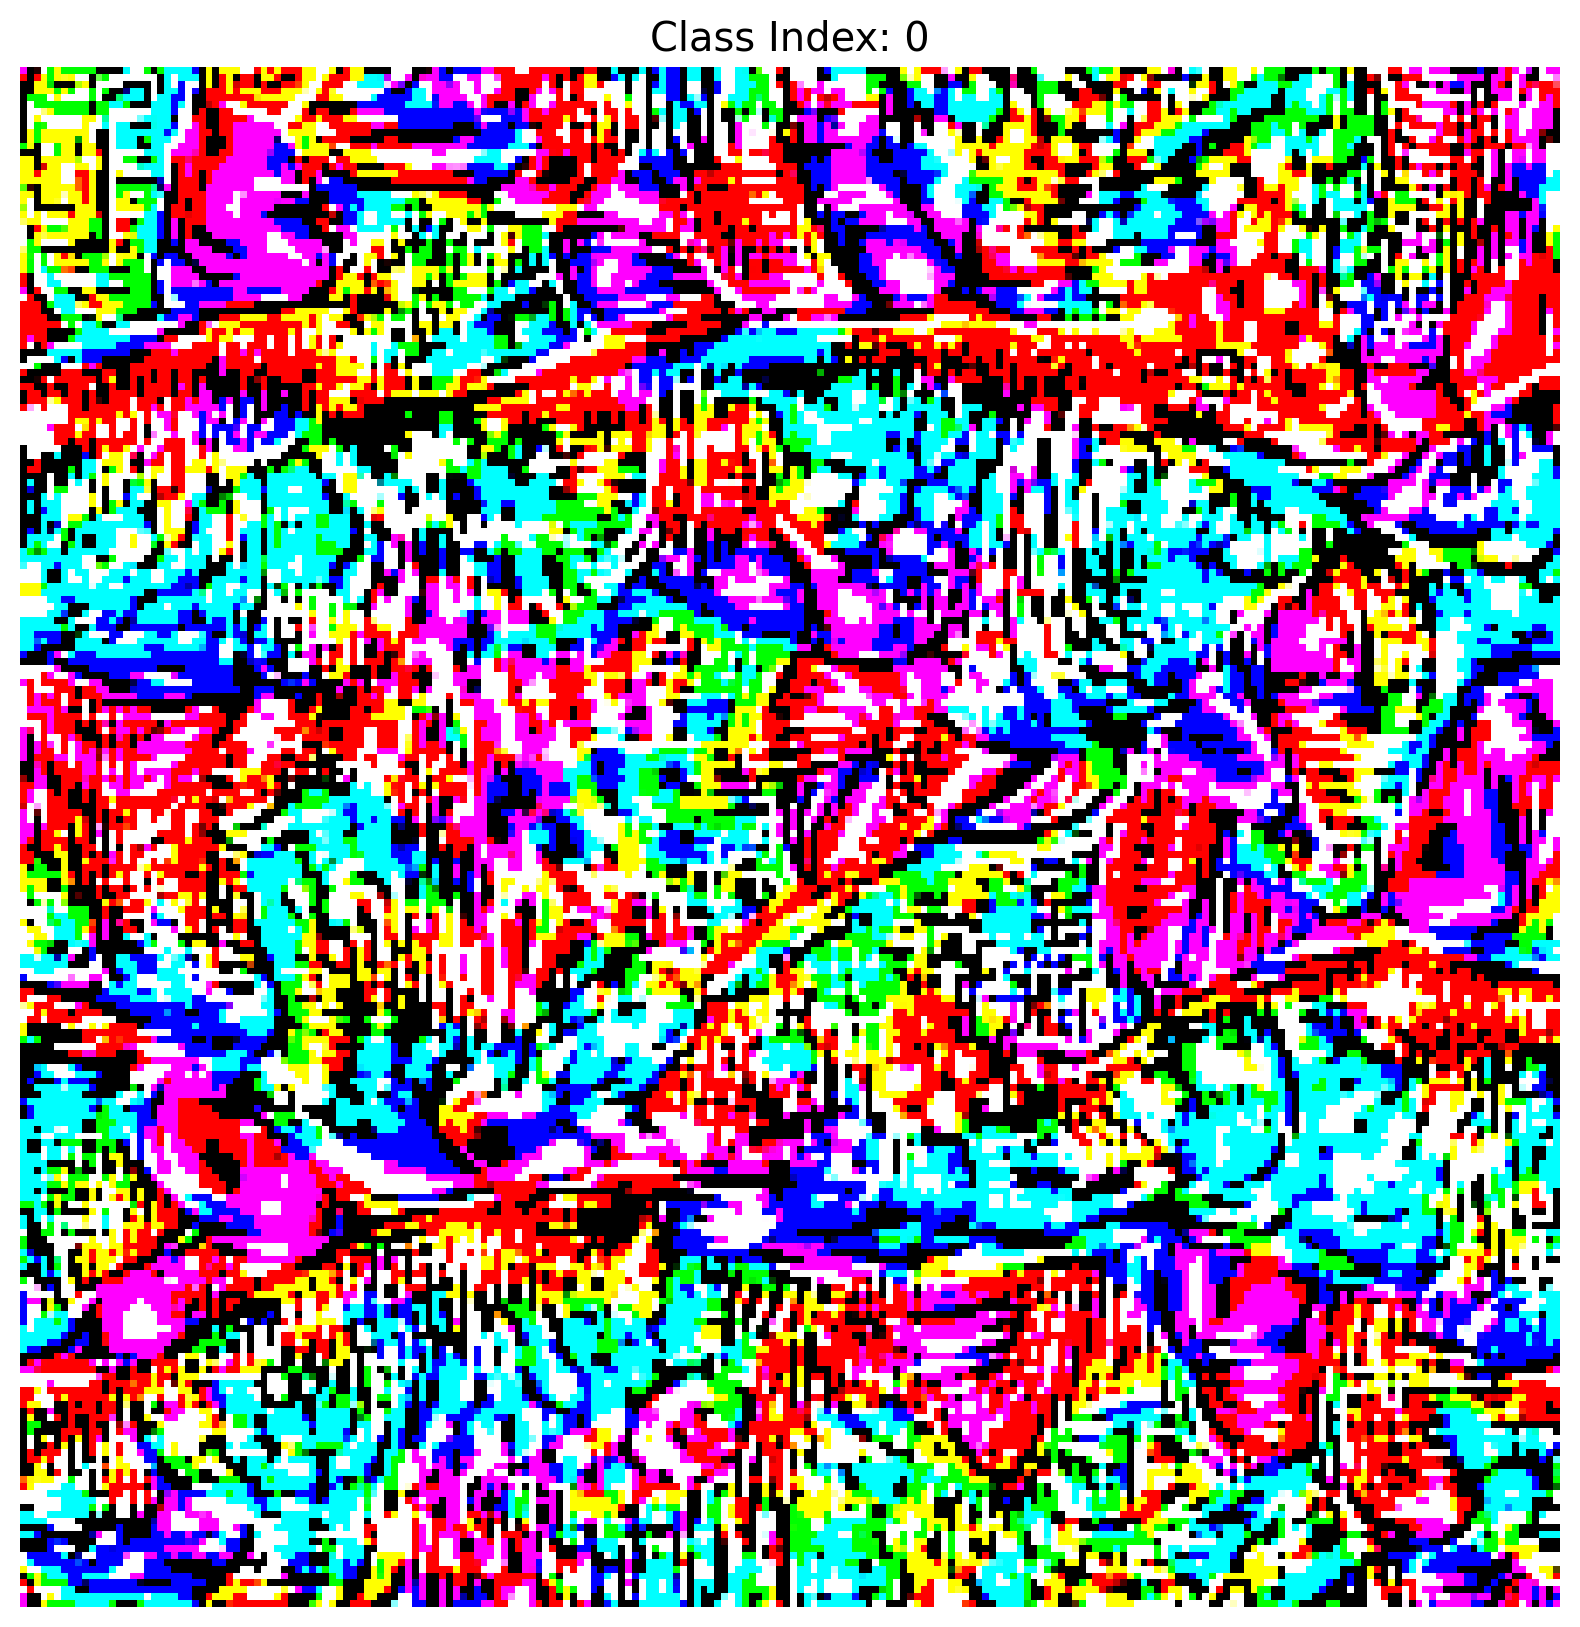

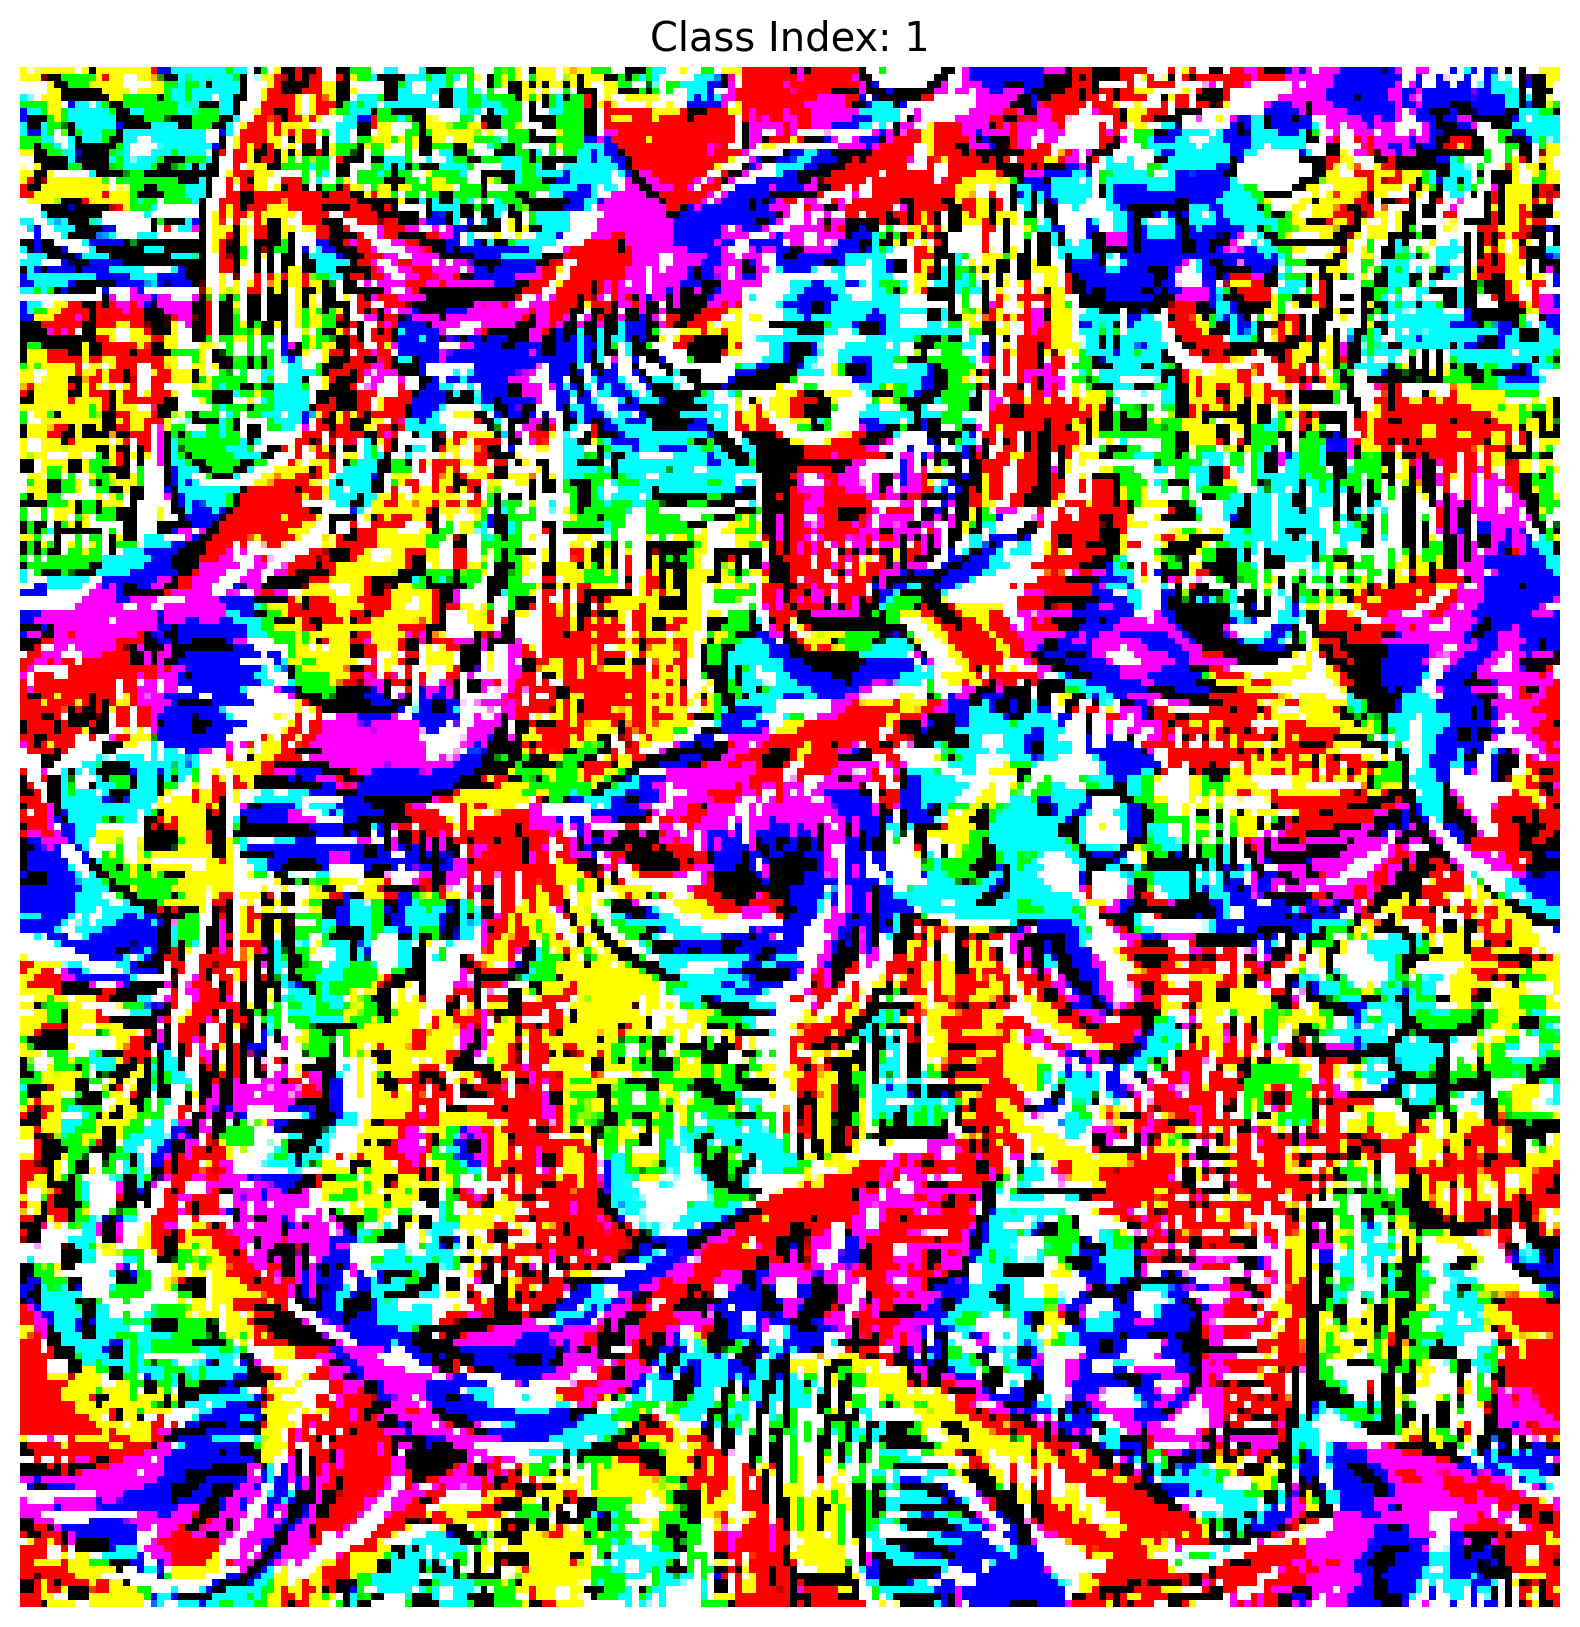

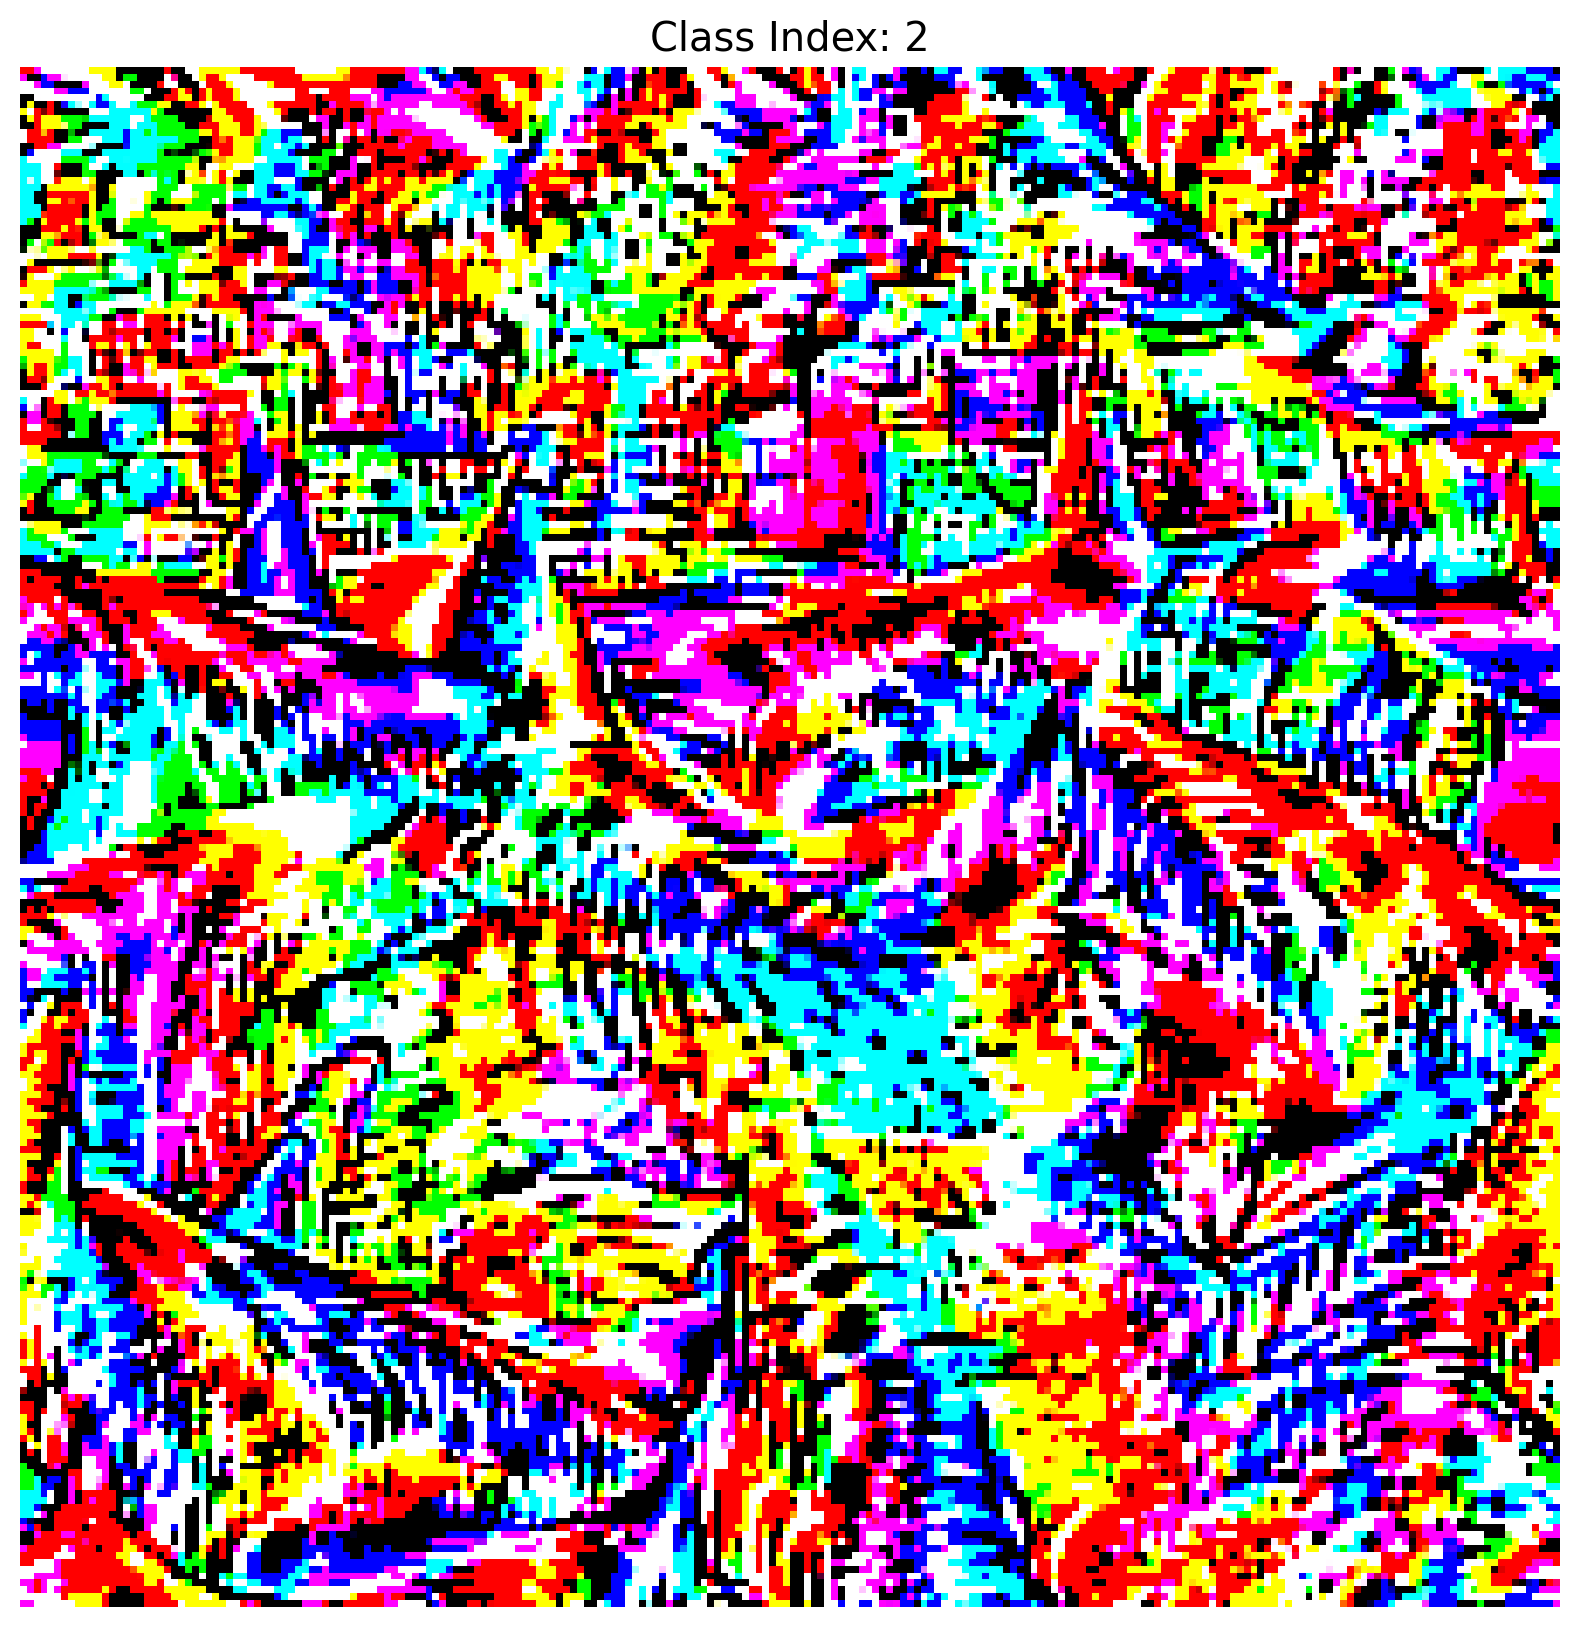

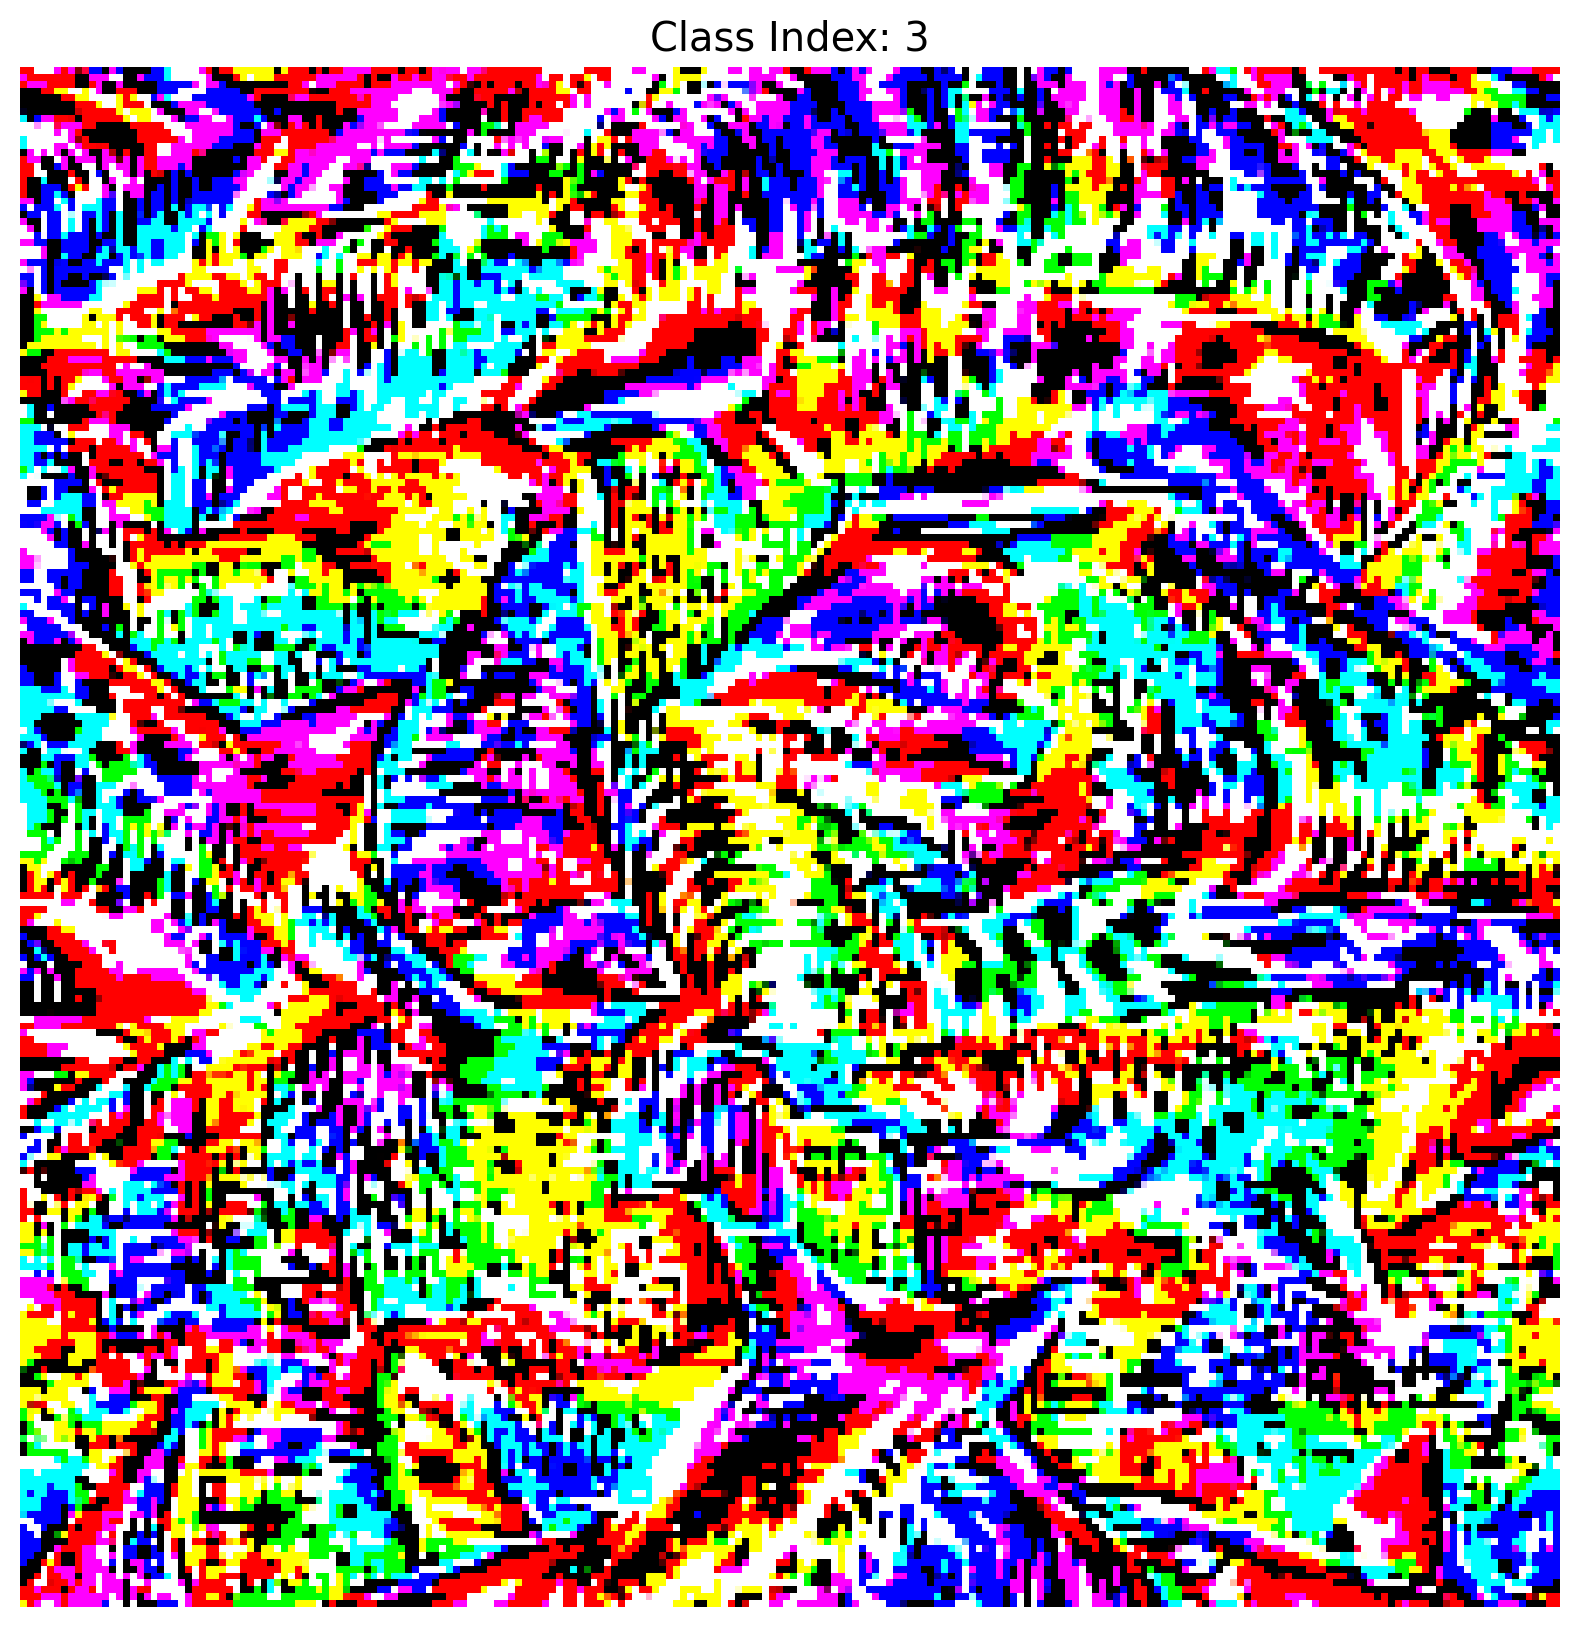

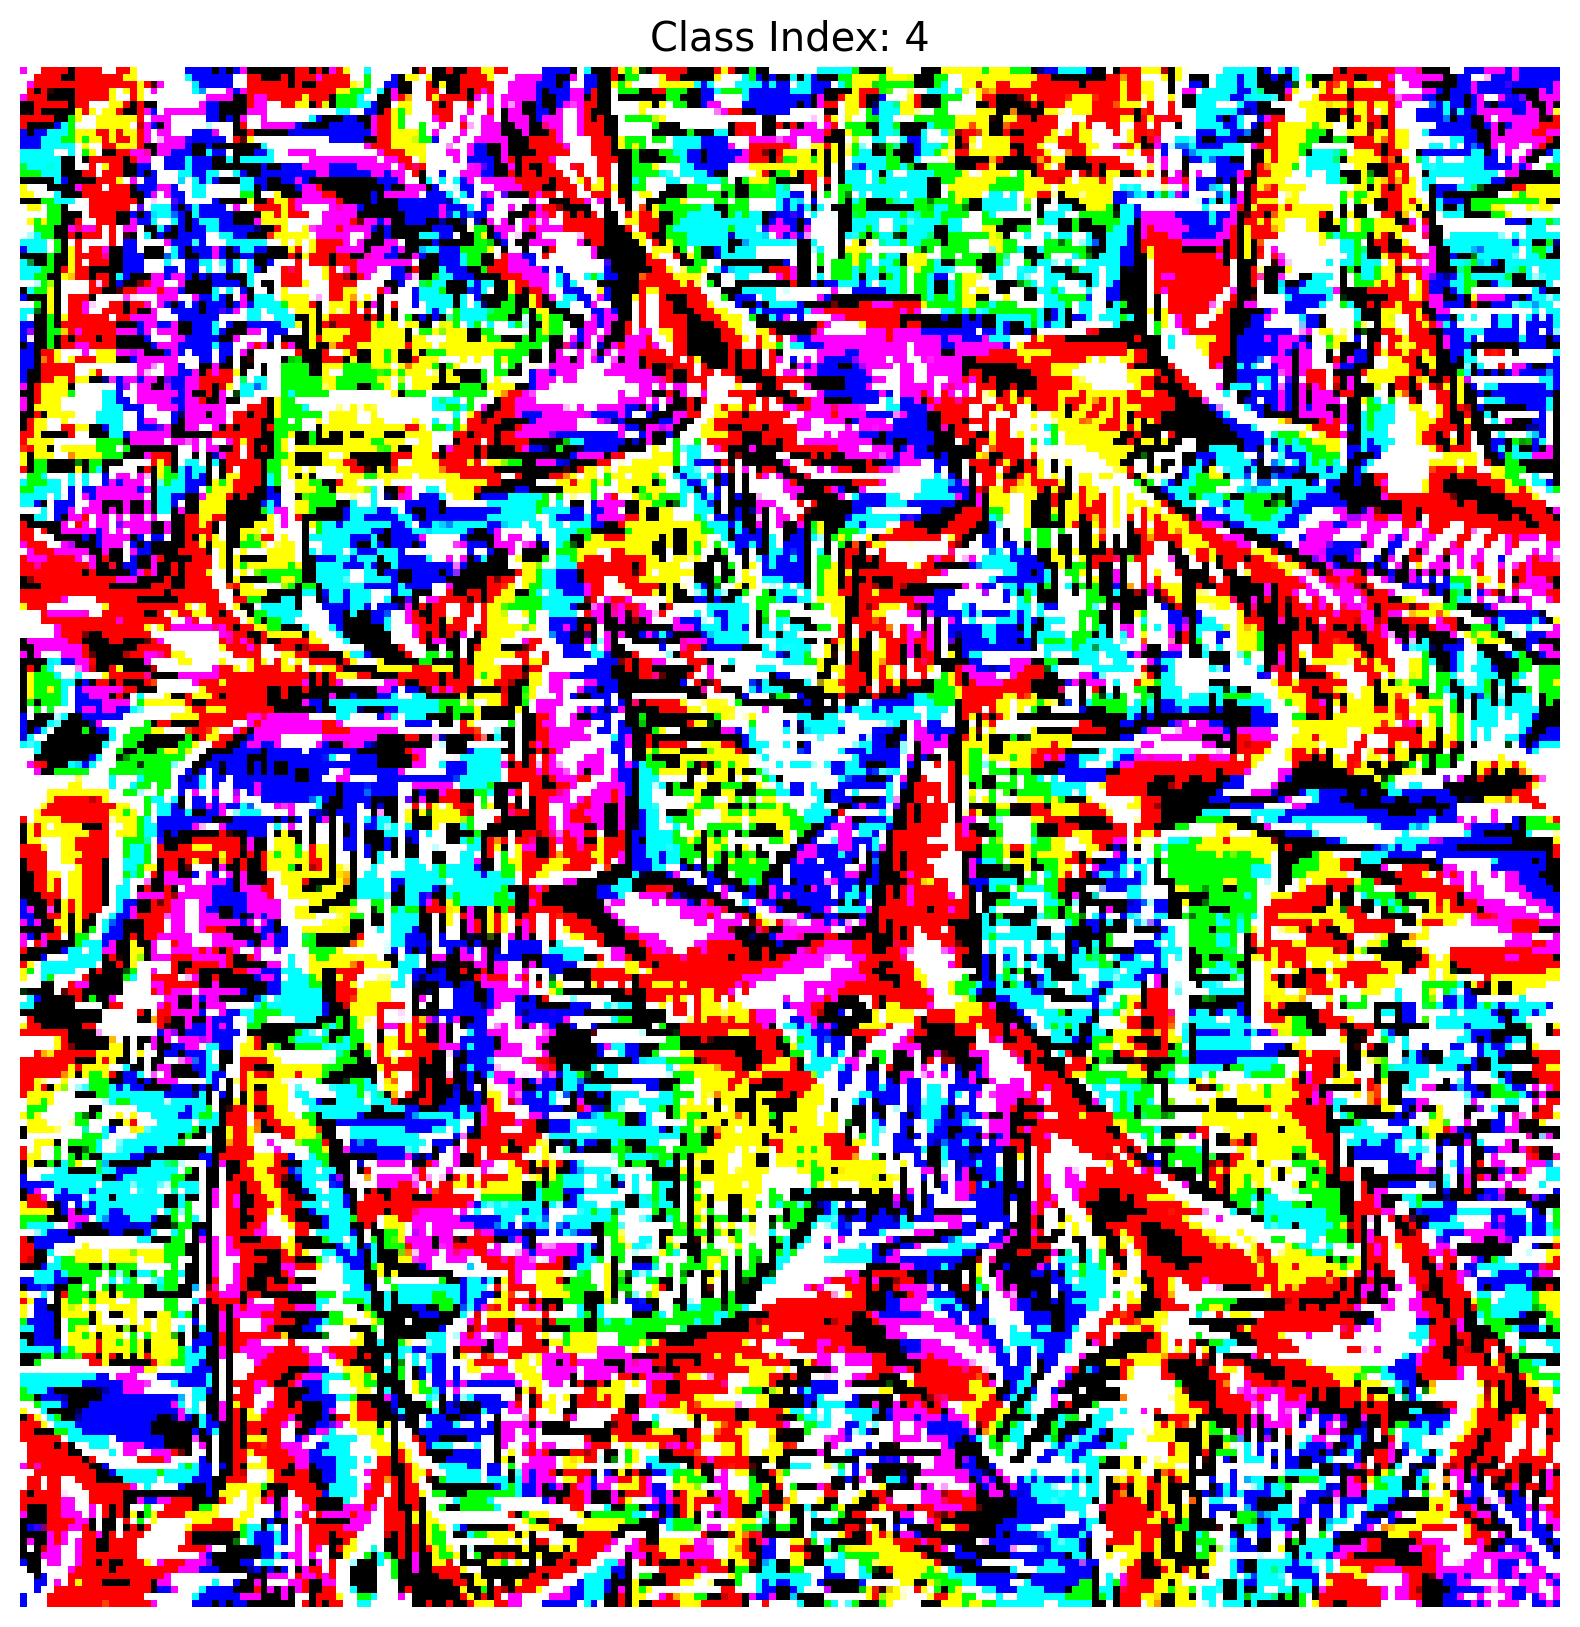

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.utils.input_modifiers import Jitter
import tf_keras_vis.utils as utils

# Load the pretrained model
model = VGG16(weights='imagenet', include_top=True)

# Modify the model to have linear output layers
model_modifier = ReplaceToLinear()

# Initialize the activation maximization technique
activation_maximization = ActivationMaximization(model, model_modifier=model_modifier)

# Define class indices for visualization
class_indices = [0, 1, 2, 3, 4]  # Example class indices, adjust as needed

# Visualize activations for each class
for class_idx in class_indices:
    # Use CategoricalScore to visualize the specific class
    score = CategoricalScore(class_idx)
    img = activation_maximization(score, seed_input=np.random.random((1, 224, 224, 3)), input_modifiers=[Jitter(16)])

    plt.figure(figsize=(10, 10))
    plt.title(f'Class Index: {class_idx}')
    plt.axis('off')
    plt.imshow(img[0])
    plt.show()


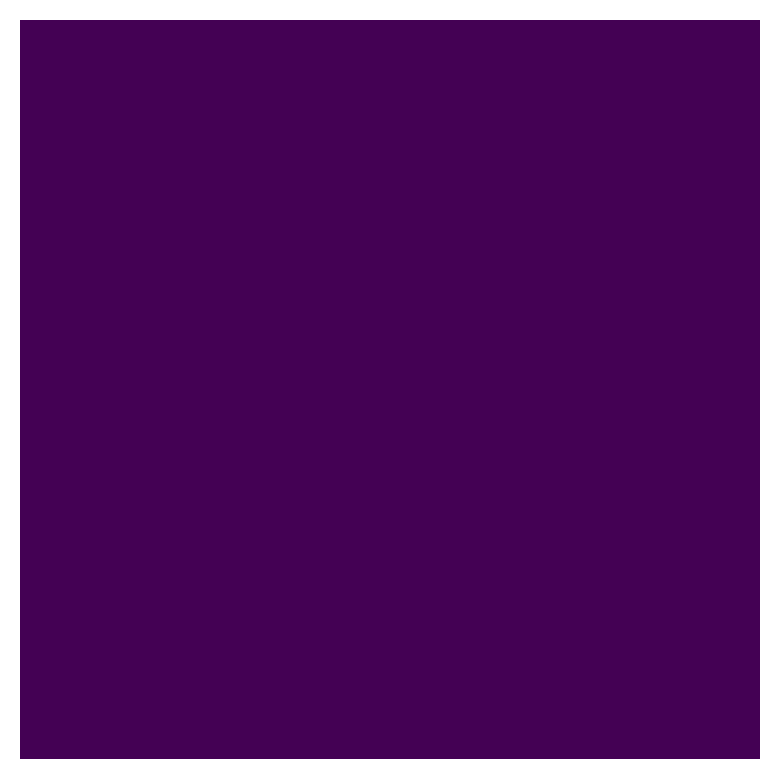

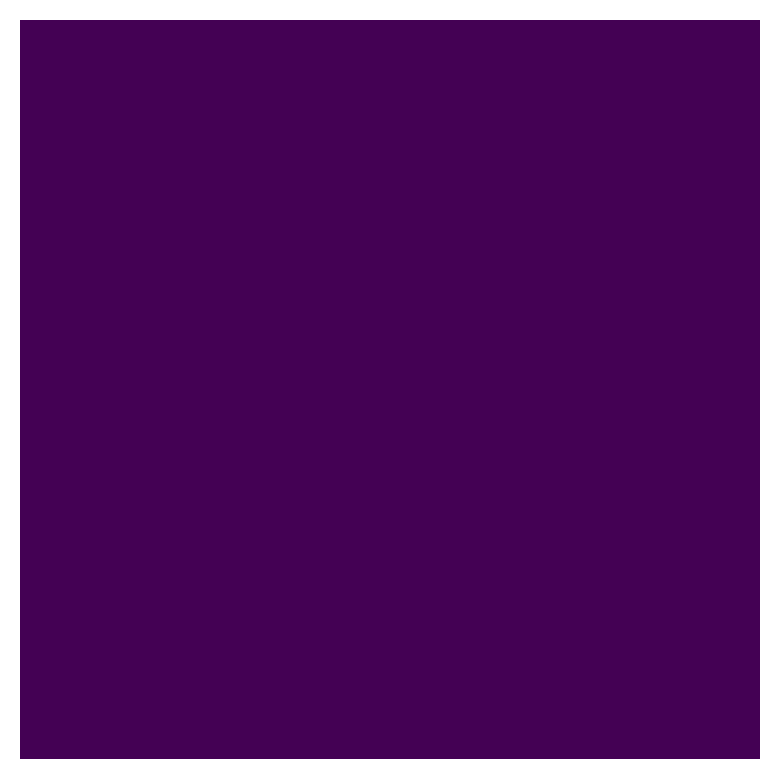

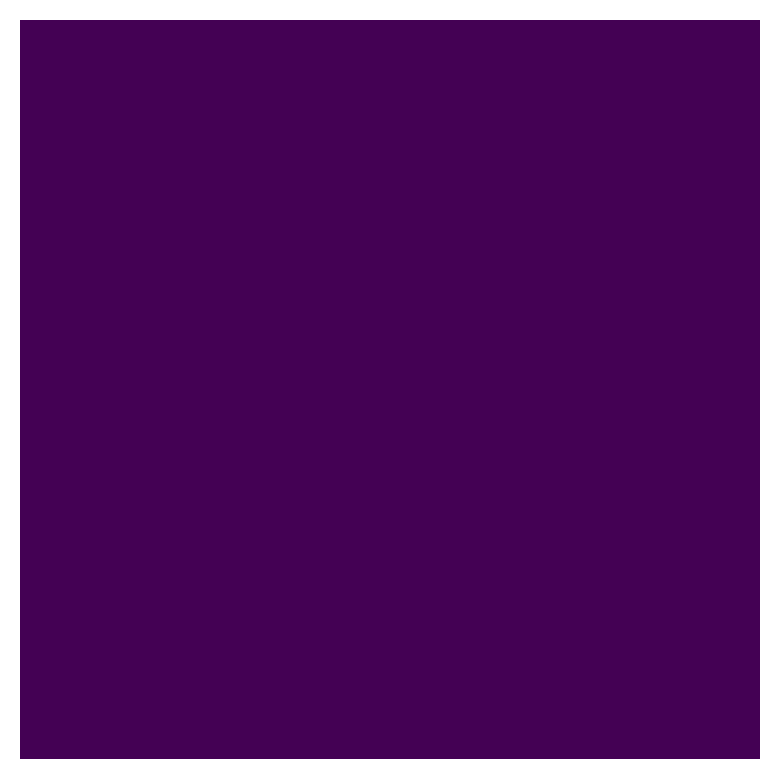

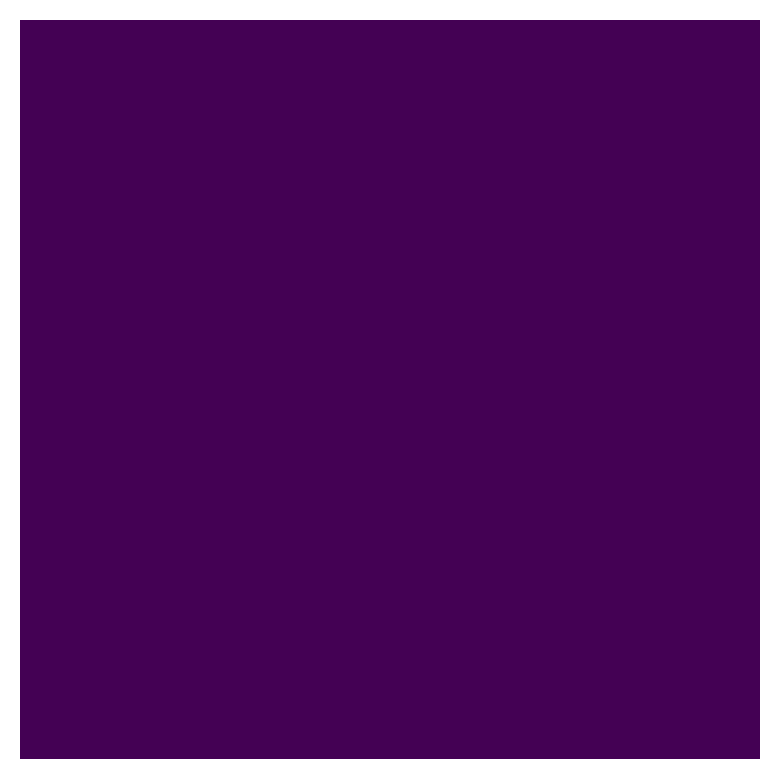

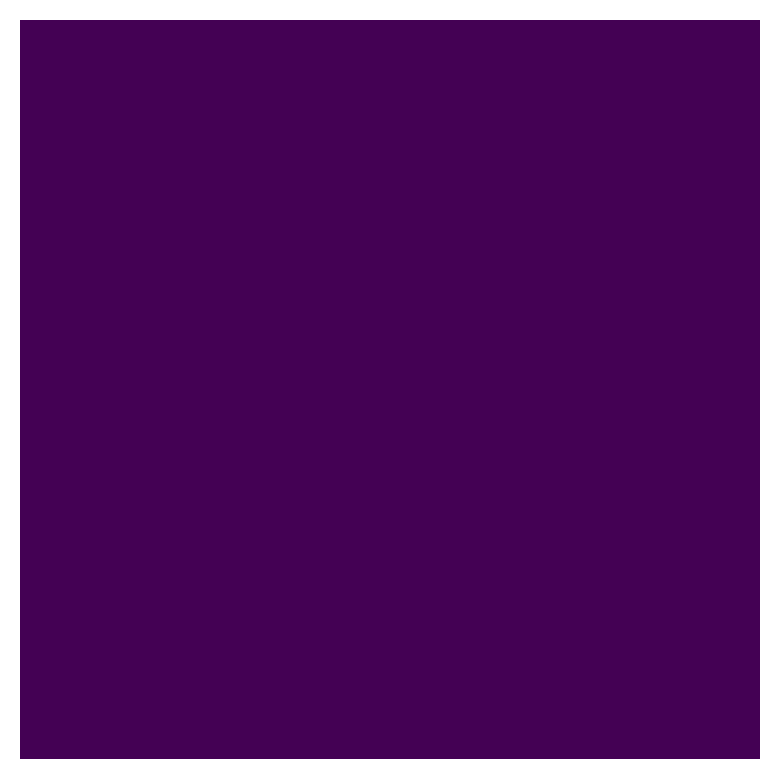

In [ ]:
import matplotlib.pyplot as plt

max_filters = 40
selected_indices = []
vis_images = [[], [], [], [], []]
i = 0

selected_filters = [
    [0, 3, 11, 25, 26, 33, 42, 62],
    [8, 21, 23, 38, 39, 45, 50, 79],
    [40, 48, 52, 54, 81, 107, 224, 226],
    [58, 79, 86, 216, 307, 426, 497, 509],
    [2, 7, 41, 84, 103, 306, 461, 487]
]

# Ejemplo de inicialización de 'stitched'
# Asegúrate de definir 'stitched' antes de usarlo
# stitched = ...

while i < len(vis_images):
    # Suponiendo que aquí realizas alguna operación para construir 'stitched'
    # Si no tienes dicha lógica, necesitarás implementarla.

    # Muestra la imagen
    plt.axis('off')
    plt.imshow(stitched)  # Asegúrate de que 'stitched' esté definido
    plt.show()
    i += 1